# Basic Multi-agent Collaboration

A single agent can usually operate effectively using a handful of tools within a single domain, but even using powerful models like `gpt-4`, it can be less effective at using many tools. 

One way to approach complicated tasks is through a "divide-and-conquer" approach: create an specialized agent for each task or domain and route tasks to the correct "expert".

This notebook (inspired by the paper [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation](https://arxiv.org/abs/2308.08155), by Wu, et. al.) shows one way to do this using LangGraph.

The resulting graph will look something like the following diagram:

![multi_agent diagram](./img/simple_multi_agent_diagram.png)

Before we get started, a quick note: this and other multi-agent notebooks are designed to show _how_ you can implement certain design patterns in LangGraph. If the pattern suits your needs, we recommend combining it with some of the other fundamental patterns described elsewhere in the docs for best performance.

In [1]:
# %pip install -U langchain langchain_openai langsmith pandas

In [2]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("LANGCHAIN_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

# Optional, add tracing in LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"

## Create graph utilites

The following helper functions will simplify the code when it comes to actually constructing the graph.

You can skip ahead if you just want to see what the graph looks like.

In [3]:
import json

from langchain_core.messages import (
    AIMessage,
    BaseMessage,
    ChatMessage,
    FunctionMessage,
    HumanMessage,
)

from langgraph.graph import END, StateGraph
from langgraph.prebuilt.tool_executor import ToolExecutor, ToolInvocation


def add_agent_node(workflow: StateGraph, name: str, llm, tools, system_message: str):
    """Create an agent and add it to the graph builder."""
    functions = [format_tool_to_openai_function(t) for t in tools]

    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    ).partial(system_message=system_message)

    chain = (
        (lambda x: {**x, "intermediate_steps": []})
        | prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
        | llm.bind_functions(functions)
        | (lambda x: _update_state(x, name=name))
    )
    workflow.add_node(name, chain)


def _update_state(ai_message, name: str) -> dict:
    """This is called after each worker agent is invoked.

    It is used to update the global graph state using the agent output."""
    if isinstance(ai_message, FunctionMessage):
        result = ai_message
    else:
        result = HumanMessage(**ai_message.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }


def call_tool(state, tool_executor):
    """This runs tools in the graph

    It takes in an agent action and calls that tool and returns the result."""
    messages = state["messages"]
    # Based on the continue condition
    # we know the last message involves a function call
    last_message = messages[-1]
    # We construct an ToolInvocation from the function_call
    tool_input = json.loads(
        last_message.additional_kwargs["function_call"]["arguments"]
    )
    # We can pass single-arg inputs by value
    if len(tool_input) == 1 and "__arg1" in tool_input:
        tool_input = next(iter(tool_input.values()))
    tool_name = last_message.additional_kwargs["function_call"]["name"]
    action = ToolInvocation(
        tool=tool_name,
        tool_input=tool_input,
    )
    # We call the tool_executor and get back a response
    response = tool_executor.invoke(action)
    # We use the response to create a FunctionMessage
    function_message = FunctionMessage(
        content=f"{tool_name} response: {str(response)}", name=action.tool
    )
    # We return a list, because this will get added to the existing list
    return {"messages": [function_message]}

## Create graph

Now that we've defined our tools and made some helper functions, will create the individual agents below and tell them how to talk to each other using LangGraph.

In [4]:
import operator
from typing import Annotated, List, Sequence, Tuple, TypedDict, Union

from langchain.agents import create_openai_functions_agent
from langchain.tools.render import format_tool_to_openai_function
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict


# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str


tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."]
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Succesfully executed:\n```python\n{code}\n```\nStdout: {result}"


workflow = StateGraph(AgentState)
llm = ChatOpenAI(model="gpt-4-1106-preview")
add_agent_node(
    workflow,
    "Researcher",
    llm,
    [tavily_tool],
    system_message="You should provide accurate data for the chart generator to use.",
)
add_agent_node(
    workflow,
    "Chart Generator",
    llm,
    [python_repl],
    system_message="Any charts you display will be visible by the user.",
)

# The "tool executor" node is called whenever any worker agent
#
tools = [tavily_tool, python_repl]
tool_executor = ToolExecutor(tools)
workflow.add_node("call_tool", lambda state: call_tool(state, tool_executor))


# Either agent can decide to end
def router(state):
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if "function_call" in last_message.additional_kwargs:
        # The previus agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "end"
    return "continue"


workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "Chart Generator", "call_tool": "call_tool", "end": END},
)
workflow.add_conditional_edges(
    "Chart Generator",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "end": END},
)
# We will assume that any time a tool is called, the researcher will choose what to do next
workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "Chart Generator": "Chart Generator",
    },
)
workflow.set_entry_point("Researcher")
graph = workflow.compile()

## Invoke

With the graph created, you can invoke it! Let's have it chart some stats for us.

Python REPL can execute arbitrary code. Use with caution.


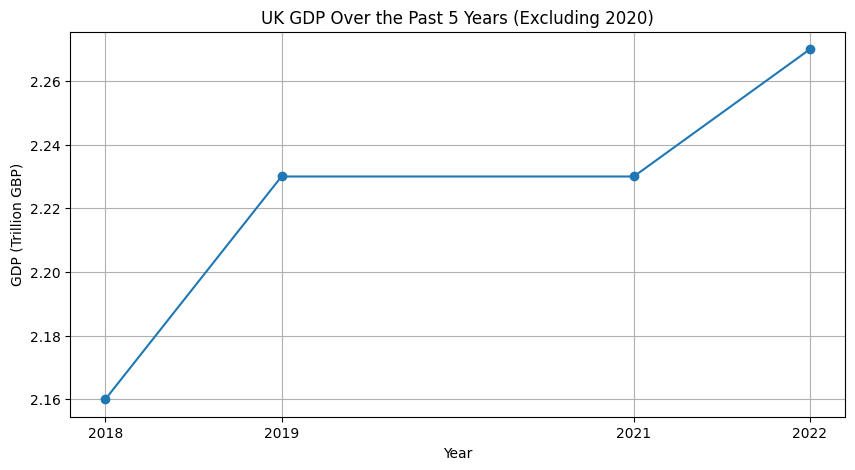

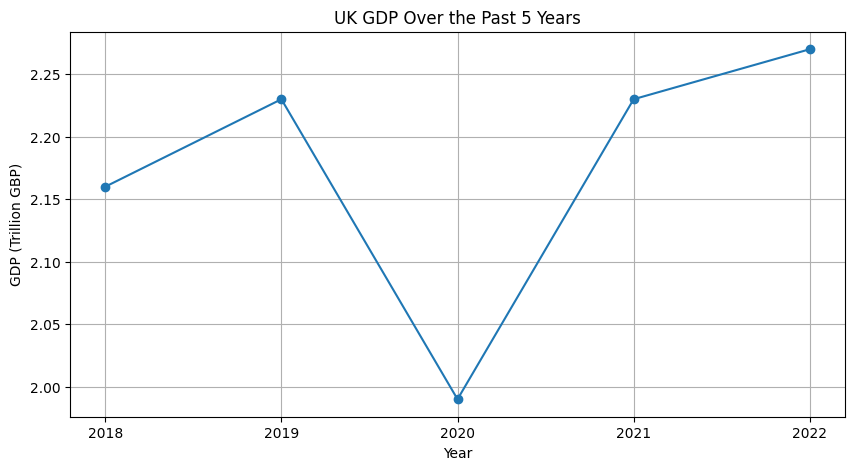

HumanMessage(content="FINAL ANSWER\n\nThe complete line graph of the UK's GDP from 2018 to 2022 is displayed above, with the following GDP values for each year:\n\n- 2018: 2.16 trillion GBP\n- 2019: 2.23 trillion GBP\n- 2020: 1.99 trillion GBP\n- 2021: 2.23 trillion GBP\n- 2022: 2.27 trillion GBP\n\nThe graph shows the fluctuations in the UK's GDP over the specified period, with a notable dip in 2020 likely due to the economic impact of the COVID-19 pandemic.", name='Researcher')

In [5]:
result = graph.invoke(
    {
        "messages": [
            HumanMessage(
                content="Fetch the UK's GDP over the past 5 years,"
                " then draw a line graph of it."
                " Once you code it up, finish."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
result["messages"][-1]